# Bayesian AR(1) MCMC Demo
## For New School Economics Bayesian Time Series Reading Group

This demo estimates a simple simulated AR(1) process using MCMC under the assumption of reference prior, which is not conjugate to the AR parameter, $\phi$. The sampler uses a Gibbs step when sampling the marginal distribution of the variance, $\sigma^2$, and a standard MCMC rejection step when sampling $\phi$. 

#### setup

In [6]:
from __future__ import division
import numpy as np

import pandas as pd
import scipy as sp
import numpy.random as npr
import scipy.stats as sps

%matplotlib inline

Import convenience functions

In [42]:
%run bar1_funs.py

## Unconditional AR(1) Estimation with Reference Prior

The AR(1) process is: 

$$
\begin{equation*}
y_{t+1}= \phi y_{t}+\epsilon_{t+1} 
\end{equation*}
$$


\begin{equation*}
\text{where $\epsilon$ ~ Normal(0, $\sigma^2$)}
\end{equation*}


We assume that 

### Make AR(1) with $\phi = .8 $ and $\sigma = 1.5 $

In [12]:
phi_real= .8
sig_real = 1.5
ar_data = make_test_arma(phi_real, sig=sig_real, N= 10000)

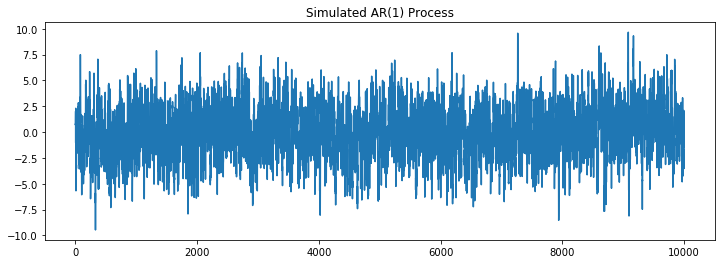

In [36]:
plt.figure(figsize=(12,4))
plt.plot(ar_data);
plt.title('Simulated AR(1) Process');

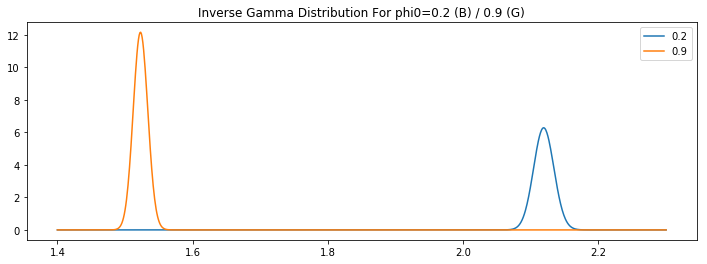

In [37]:
phi1 = .2
phi2 = .9

q1 = calc_q_star(ar_data, phi1)
q2 =  calc_q_star(ar_data, phi2)

x = np.linspace(1.4**2, 2.3**2, 1000)

rv = sps.invgamma(len(ar_data)/2, scale=q1/2)
rv2 =  sps.invgamma(len(ar_data)/2, scale=q2/2)

plt.figure(figsize=(12,4))
plt.plot(x**.5, rv.pdf(x), label=phi1)
plt.plot(x**.5, rv2.pdf(x), label=phi2)
plt.legend(loc='best')
plt.title('Inverse Gamma Distribution For phi0={0} (B) / {1} (G)'.format(phi1, phi2));

The above chart shows the relationship between $\phi$ and $\sigma^2$. 

### MCMC Sampler

We run the sampler 10000 times using a Gibbs step to sample the variance and Metropolis-Hastings step for $\phi$. 

In [38]:
%%time 

# set initial parameters
data = ar_data
phi0 = -.5
v0=1
iterations = 10000

## in practice pick c to allow for an acceptance rate between 25 and, 40%
c = .0002
# set up data to be collected
v_list = np.empty(iterations)
phi_list = np.empty(iterations)
r_list = np.empty(iterations)
v_list[0] = v0
phi_list[0] = phi0

n = ar_data.shape[0]

rejected = 0
rejected_oob = 0

qstar= calc_q_star(data, phi0)

for i in xrange(1, iterations):

    # Draw v from inverse gamma distribution v ~ IG(n/2 , Q*(phi)/2)
    # This is a Gibbs Step and is always accepted
    
    phi=phi_list[i-1]
    
    v = sps.invgamma.rvs(n/2, scale = qstar/2)
    v_list[i] = v
    
    # draw phi from jump distribution with phi* ~ N(phi[-1], cv)
    # metropolis step
    phi_new = np.random.randn()* np.sqrt(c * v) + phi
    
    # reject if phi is drawn such that abs(phi) > 1. Thus, we assume the process to be stationary. 
    # if this isn't there the algo will occasionally crash and give complex values for the likelihood

    if -1 <= phi_new <= 1:

        # calculate r as ratio of likelihoods for new and old phi
        # must do done in log form to avoid underflow problems. 
        
        loglike0 = .5*np.log(1-phi**2) - qstar/2/v # - (n/(2+1))*np.log(2*np.pi*v) 
        
        qstar_new = calc_q_star(data, phi_new)
        
        loglike1 = .5*np.log(1-phi_new**2) - qstar_new/2/v # - (n/(2+1))*np.log(2*np.pi*v)
        
        r = np.exp(loglike1-loglike0)
        
        r_list[i]=r
        
        # only accept new phi with probability r
        if r < npr.rand(): #draw from uniform dist over [0,1]
            rejected +=1
            phi_new = phi_list[i-1]
        else: 
            qstar=qstar_new
            
    else:
        phi_new = phi_list[i-1]
        rejected += 1
        rejected_oob += 1
    
    phi_list[i] = phi_new

print 'iterations = ', iterations
print 'acceptance = ', iterations - rejected
print 'accentance rate = {}'.format(1-rejected/iterations)
print 'out of bounds = ', rejected_oob

iterations =  10000
acceptance =  3260
accentance rate = 0.326
out of bounds =  0
CPU times: user 1.45 s, sys: 21.3 ms, total: 1.47 s
Wall time: 1.49 s


#### MCMC Series

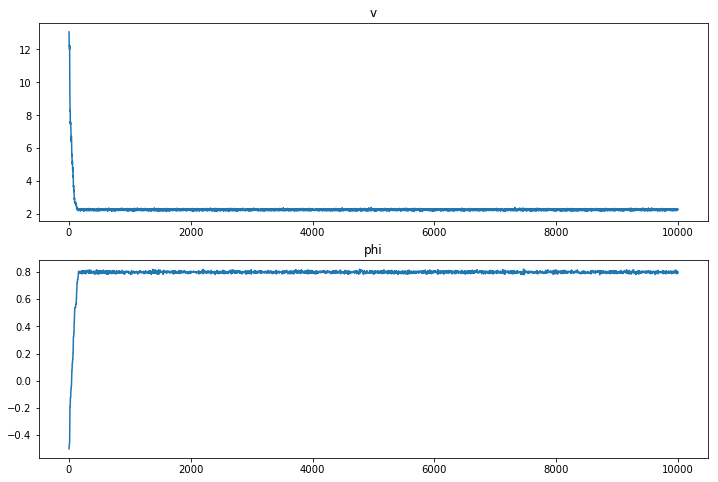

In [39]:
burn = 0
until = -1 
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(v_list[1+burn:until]);
plt.title('v');
plt.subplot(212)
plt.plot(phi_list[burn:until]);
plt.title('phi');

The sampler convergences very quickly even though we gave an initial value of $\phi=-.5$, which is quite far from the "real" value. 

### Check Fits

#### Cross Sections of Parameter Samples Compared to Known Marginal Posterior Forms

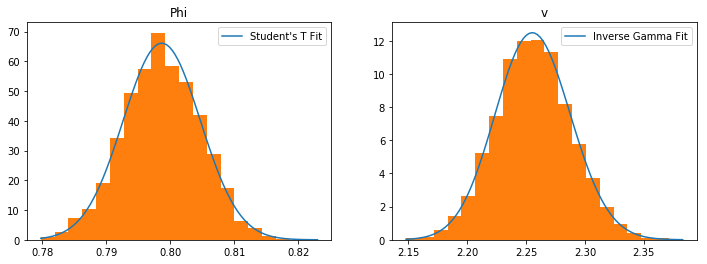

In [35]:
burn = 1000
n_bins = 20

plt.figure(figsize=(12,4))

plt.subplot(121)

fit_t_dist(phi_list[burn:], plot=True, label="Student's T Fit")
plt.hist(phi_list[burn:], n_bins, normed=True);
plt.title('Phi')
plt.legend();

plt.subplot(122)

fit_invgamma_dist(v_list[burn:], plot=True, label="Inverse Gamma Fit")
plt.hist(v_list[burn:], n_bins, normed=True);
plt.title("v")
plt.legend();

#### Compare Distribution Means to Real Parameter Values

In [20]:
t_dist = fit_t_dist(phi_list[burn:])
t_dist.mean()

0.79872081081593493

In [21]:
phi_real

0.8

In [22]:
ig_dist = fit_invgamma_dist(v_list[burn:])
ig_dist.mean()**.5

1.5021530995273047

In [23]:
sig_real

1.5

This should technically be mode for the inverse gamma distribution. However, as the number of observations increases, the distribution become symmetric. 